Cet technique marche beaucoup mieux que dans tensorflow, avec en très peu de temps.
Ce modèle fonctionne mieux que l'autre dans tensorflow parce qu'une raison évidente: il utilise méthode teacher forcing
Un autre problème avec ce méthode, c'est dropout qui donne une technique plus ou moins bon. Il donne la réponse plus tôt aléatoire pour une question. En cas général, ce la peut être intéressant, mais dans notre cas, il est très important qu'il capture le mot clés (donc, surtout on risque de  supprimer le mot clés, qui rendra une mauvais réponse)

In [1]:
"""
Cet technique marche beaucoup mieux que dans tensorflow, avec en très peu de temps. 
Ce modèle fonctionne mieux que l'autre dans tensorflow parce qu'une raison évidente: 
il utilise méthode teacher forcing Un autre problème avec ce méthode, 
c'est dropout qui donne une technique plus ou moins bon. Il donne la 
réponse plus tôt aléatoire pour une question. En cas général, 
ce la peut être intéressant, mais dans notre cas, il est très important 
qu'il capture le mot clés 
(donc, surtout on risque de supprimer le mot clés, qui rendra une mauvais réponse)
modèle est bien entrainé, donc, il ne sert à rien d'entrainer encore.
"""
#from IPython.display import display, Markdown
#display(Markdown("### Pour lancer un chat, il suffit de taper en même temps CTRL et ENTER"))
#display(Markdown("### Pour arrêter le mode chat, il suffit de taper ENTER dans votre conversation"))
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import data
import config

use_cuda = torch.cuda.is_available()

SOS_token  = config.SOS_token
EOS_token  = config.EOS_token
MAX_LENGTH = config.MAX_LENGTH
stopwords  = config.STOPWORDS
learning_rate = config.LEARNING_RATE
teacher_forcing_ratio = config.TEACHER_FORCING
dropout = config.DROPOUT
hidden_size = 70

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    """
    Whith a tring s, we make it in lower case, delete \n if exists at 
    the end of string, and delete specical case ? . and !
    """
    s = s.lower().strip()
    s = re.sub(r"([,.!?\n])", r"", s)# sumprimer tous les caractères .! et ?
    #s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s

def readLangs(questions, answers, reverse=False):
    print("Reading lines...")
    pairs = []   
    encode_file = open(os.path.join(config.PROCESSED_PATH, "question.txt"), 'r')
    decode_file = open(os.path.join(config.PROCESSED_PATH, "answer.txt"), 'r')
    encode, decode = encode_file.readline(), decode_file.readline()
    while encode and decode:
        encode, decode = normalizeString(encode), normalizeString(decode)
        pairs.append([encode, decode])
        encode, decode = encode_file.readline(), decode_file.readline()

    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(answers)
        output_lang = Lang(questions)
    else:
        input_lang = Lang(questions)
        output_lang = Lang(answers)

    return input_lang, output_lang, pairs

def TrimWords(pairs):
    for pair in pairs: #[pair for pair in pairs]:
        resultwords  = [word for word in pair[0].split() if word.lower() not in stopwords]
        pair[0] = ' '.join(resultwords)
    return pairs

 
def TrimWordsTest(question):
    resultwords  = [word for word in question.split() if word.lower() not in stopwords]
    question = ' '.join(resultwords)
    return question


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = TrimWords(pairs)
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=dropout, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        #embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))#, dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))#, dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
def closetWord(word, lang):
    """
    find and return the closest word in lang
    """
    Dict = lang.word2index
    corpus = lang.index2word
    if word in Dict:
        return word
    else:
        distance = levenshtein(word, corpus[0])
        close_word = corpus[0]
        for ix in corpus:
            if levenshtein(word, corpus[ix]) <distance:
                close_word = corpus[ix]
                distance = levenshtein(word, corpus[ix])
        if distance <=2:
            return close_word
        else:
            return ''
def normalizeSentenceInChat(sentence):
    sentence = sentence.strip().lower().split()
    s = [closetWord(word, input_lang) for word in sentence]
    return ' '.join(s)
        
        
            

def indexesFromSentence(lang, sentence):
    #sentence = normalizeSentence
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index ]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)


def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def trainIters(n_iters, print_every=1000, plot_every=100, learning_rate=learning_rate):
    encoder, decoder = restore_model()
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    save_model(encoder, decoder)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    sentence = normalizeSentenceInChat(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        ni = int(ni)
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(n):
    encoder, decoder = restore_model()
    for i in range(n):
        pair = random.choice(pairs)
        print('Question: ', pair[0])
        print('Réponse: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[:-1])
        print('Bot: ', output_sentence)
        print('-'*50)
        
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
def save_model(encoder, decoder):        
    make_dir(config.CHECK_POINT_PATH)
    path1= os.path.join(config.CHECK_POINT_PATH, 'encoder_70.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_70.ck')
    try: 
        os.remove(path1)  
        os.remove(path2)
    except FileNotFoundError:
        pass
    torch.save(encoder,path1)
    torch.save(decoder, path2)
    
memo = {}
def levenshtein(s, t):
    """
    Pour calculer la distance  Levenshtein entre 2 string s et t
    """
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    cost = 0 if s[-1] == t[-1] else 1
       
    i1 = (s[:-1], t)
    if not i1 in memo:
        memo[i1] = levenshtein(*i1)
    i2 = (s, t[:-1])
    if not i2 in memo:
        memo[i2] = levenshtein(*i2)
    i3 = (s[:-1], t[:-1])
    if not i3 in memo:
        memo[i3] = levenshtein(*i3)
    res = min([memo[i1]+1, memo[i2]+1, memo[i3]+cost])
    
    return res
    
def restore_model():
    hidden_size = config.HIDDEN_SIZE
    path1 = os.path.join(config.CHECK_POINT_PATH, 'encoder_70.ck')
    path2 = os.path.join(config.CHECK_POINT_PATH, 'decoder_70.ck')
    if os.path.exists(path1)and os.path.exists(path2):
        print('Reading the parameters from {}...'.format(config.CHECK_POINT_PATH))
        encoder = torch.load(path1)
        decoder = torch.load(path2)
    else:
        print('Initializing fresh parameters...')
        encoder = EncoderRNN(input_lang.n_words, hidden_size)
        decoder = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               1, dropout_p=0.1)

    if use_cuda:
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    return encoder, decoder  
def chat():
    encoder, decoder = restore_model()
    make_dir(config.CHECK_POINT_PATH)
    output_file = open(os.path.join(config.CHECK_POINT_PATH, config.OUTPUT_FILE), 'a+')
    print('Bonjour, c\'est le Bot d\'AVICEN, Je peux vous aider? \n')
    while True:
            line = str(input('Vous: '))
            if len(line) > 0 and line[-1] == '\n':
                line = line[:-1]
            if line == '':
                break
            line = normalizeString(line)
            output_file.write('VOUS ++++ ' + line + '\n')
            reponse, _ = evaluate(encoder, decoder, line)
            reponse = " ".join(reponse[:-1])
            output_file.write('BOT ++++ ' + reponse + '\n')
            print('Bot AVICEN: ', reponse)
            print('-'*50)
    output_file.close()
try:
    input_lang
except NameError : 
    input_lang, output_lang, pairs = readLangs('questions', 'answers', False)
    pairs = TrimWords(pairs) 
    input_lang, output_lang, pairs = prepareData('questions', 'answers', False)

def langTest():
    pairs_test = []   
    test_file = open(os.path.join(config.PROCESSED_PATH, "test.txt"), 'r')
    i=0
    for line in test_file:
        line = normalizeString(line)
        if i%2 ==0:
            question = line
        else:
            answer = line
            pairs_test.append([question, answer])
        i +=1
    return pairs_test  

def test(pairs_test):
    """
    Use test for know how our model is good
    """
    encoder, decoder = restore_model()
    total_loss = 0
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    for pair in pairs_test:
        variable = variablesFromPair(pair)
        loss = train( variable[0], variable[1], encoder, decoder, encoder_optimizer, decoder_optimizer,\
                     criterion= criterion)
        total_loss +=loss
    Length_inputs = len(pairs_test) if len(pairs_test) !=0 else 1
    return total_loss/Length_inputs

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Reading lines...
Reading lines...
Read 555 sentence pairs
Trimmed to 548 sentence pairs
Counting words...
Counted words:
questions 594
answers 772


Reading the parameters from check_point...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:202: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:213: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:325: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0m 5s (- 0m 51s) (1000 10%) 0.0638
0m 11s (- 0m 45s) (2000 20%) 0.0562
0m 16s (- 0m 39s) (3000 30%) 0.0573
0m 22s (- 0m 33s) (4000 40%) 0.0541
0m 27s (- 0m 27s) (5000 50%) 0.0647
0m 33s (- 0m 22s) (6000 60%) 0.0598
0m 39s (- 0m 16s) (7000 70%) 0.0414
0m 44s (- 0m 11s) (8000 80%) 0.0534
0m 50s (- 0m 5s) (9000 90%) 0.0555
0m 56s (- 0m 0s) (10000 100%) 0.0613


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AttnDecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

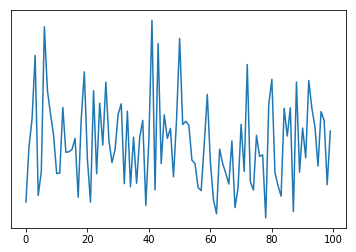

In [4]:
trainIters(10000)

In [4]:
chat()

Reading the parameters from check_point...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: combien de véhicules  sont utilisés aujourd'hui


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:201: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:212: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Bot AVICEN:  la
--------------------------------------------------
Vous: combien de véhicules sont roulés
Bot AVICEN:  #total_veh_movement#
--------------------------------------------------
Vous: combien de véhicules sont utilisés
Bot AVICEN:  #oui/non#
--------------------------------------------------
Vous: combien de voitures sont roulées
Bot AVICEN:  #total_veh_movement#
--------------------------------------------------
Vous: combien de voitures sont à l'arrêt
Bot AVICEN:  ce véhicule #vin# semble immobilisé
--------------------------------------------------
Vous: combien de voitures sont immobilisées?
Bot AVICEN:  #list_vin_free# véhicules de ce véhicule
--------------------------------------------------
Vous: combien de véhicules sont immobilisés
Bot AVICEN:  #list_vin_free# véhicules du parc sont
--------------------------------------------------
Vous: est-ce-que tout va bien
Bot AVICEN:  ça va et toi
--------------------------------------------------
Vous: est ce que tout va 

In [3]:
trainIters(3000)

Reading the parameters from check_point...


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:202: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:213: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:325: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THNN/generic/ClassNLLCriterion.c:97